# Introduction
This notebook accesses if the extensiveness of the studies on the known phosphosite effects:
1. prediction score 
2. predicted substrate network degrees

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import meltMatrix, df_by_kin

In [2]:
# file location
# local (../../)
base = '../../'


In [221]:
# annotation file
annot = base + 'KinaseActivity/Data/PhosphoproteomeDatasets/Mapped_ProteomeScout_all_annotated_June30_2020.csv'

# prediction data 
input_dir = 'Kinase Predictions/Data/comparison/Thresh/'

PhosphoPICK1 = base + input_dir + 'PhosphoPICK/all/PhosphoPICK_0.1.csv'    #low
PhosphoPICK06 = base + input_dir + 'PhosphoPICK/all/PhosphoPICK_0.06.csv'  #med
PhosphoPICK02 = base + input_dir + 'PhosphoPICK/all/PhosphoPICK_0.02.csv'  #high

NetworKIN03 = base + input_dir + 'NetworKIN/all/NetworKIN_0.3.csv'         #low
NetworKIN05 = base + input_dir + 'NetworKIN/all/NetworKIN_0.5.csv'         #med
NetworKIN1 = base + input_dir + 'NetworKIN/all/NetworKIN_1.csv'            #high

GPS_lo = base + input_dir + 'GPS5.0/all/GPS_low.csv'                       #low
GPS_md = base + input_dir + 'GPS5.0/all/GPS_medium.csv'                    #med
GPS_hi = base + input_dir + 'GPS5.0/all/GPS_high.csv'                      #high

# output dir
plot_dir = base + 'Kinase Predictions/Data/comparison/studyBias/'


In [5]:
# load annotation file
cols = ['KSTAR_ACCESSION', 'KSTAR_PEPTIDE', 'KSTAR_SITE', 'evidence', 'numCompendia', 'uniqueExpt']
annot_df = pd.read_csv(annot, usecols = cols)
annot_df

,evidence,numCompendia,uniqueExpt,KSTAR_ACCESSION,KSTAR_PEPTIDE,KSTAR_SITE
0,[1790],1,1,P18825,GALTASRsPGPGGRL,S338
1,"[1718, 1790]",1,2,P18825,LSRASSRsVEFFLSR,S352
2,[1718],0,1,P18825,RSVEFFLsRRRRARS,S358
3,[1790],1,1,Q9NZK5,LLLAVAMsFFGSALS,S22
4,[1790],1,1,Q9NZK5,VAMSFFGsALSIDET,S26
...,...,...,...,...,...,...
245243,"[1395, 1575, 1790]",3,3,Q96MU7,QEVDRRFsGVRRDVF,S577
245244,"[1718, 1719, 1723, 1790]",1,3,Q96MU7,RDVFLNGsYNDYVRE,S588
245245,[1790],1,1,Q96MU7,RDKRVHDyDMRVDDF,Y656
245246,[1790],1,1,Q96MU7,VDDFLRRtQAVVSGR,T667


In [222]:
# load df, convert the matrix to a list-like df
# PhosphoPICK
pp1_df = meltMatrix.meltMatrix(PhosphoPICK1)
pp06_df = meltMatrix.meltMatrix(PhosphoPICK06)
pp02_df = meltMatrix.meltMatrix(PhosphoPICK02)
# NetworKIN
nw03_df = meltMatrix.meltMatrix(NetworKIN03)
nw05_df = meltMatrix.meltMatrix(NetworKIN05)
nw1_df = meltMatrix.meltMatrix(NetworKIN1)
# GPS
gpsl_df = meltMatrix.meltMatrix(GPS_lo)
gpsm_df = meltMatrix.meltMatrix(GPS_md)
gpsh_df = meltMatrix.meltMatrix(GPS_hi)


In [223]:
# group and define df as y kinase and s/t kinase groups
# PhosphoPICK
pp1_y, pp1_st = df_by_kin.df_by_kin(pp1_df)
pp06_y, pp06_st = df_by_kin.df_by_kin(pp06_df)
pp02_y, pp02_st = df_by_kin.df_by_kin(pp02_df)
# NetworKIN
nw03_y, nw03_st = df_by_kin.df_by_kin(nw03_df)
nw05_y, nw05_st = df_by_kin.df_by_kin(nw05_df)
nw1_y, nw1_st = df_by_kin.df_by_kin(nw1_df)
# GPS
gpsl_y, gpsl_st = df_by_kin.df_by_kin(gpsl_df)
gpsm_y, gpsm_st = df_by_kin.df_by_kin(gpsm_df)
gpsh_y, gpsh_st = df_by_kin.df_by_kin(gpsh_df)


### Score Median Distribution vs. Number of Compendia

In [231]:
def prep_median_df (df, annot_df):
    """
    get the number of Compendia of a predicted site
    by merge the prediction df with the annotation df
    
    Parameters
    ----------
    df:       prediction dataframe
    annot_df: annotation dataframe
    
    Returns
    --------
    df: merged dataframe
    """
    # change the numbCompendia column as int
    annot_df = annot_df.astype({'numCompendia':int})
    # merge the prediction df with the annatation df by substrate accession to get the numbCompendia group
    df = df.merge(annot_df, left_on=['substrate_acc','site'], right_on=['KSTAR_ACCESSION', 'KSTAR_SITE'], how = 'left')
    # drop any unmapped site (due to different version of human proteome on PreoteomeScout)
    df = df.dropna(subset=['numCompendia', 'uniqueExpt'])

    return df

In [250]:
def plot_score_numCompendia (df, predictor, thresh, kinase):
    """
    plot prediction score median distributions by numbCompendia
    
    Parameters
    ----------
    df:  prediction dataframe
    predictor: 
        'PhosphoPICK', 'NetworKIN', 'GPS'
    thresh: 
        'low','med','high'
    kinase:
        'Y_kinase','ST_kinase'
        
    Returns
    --------
    ks_result: KS test result summary of the prediction scores median between numCompendia groups
    """
    if kinase == 'Y_kinase':
        kin_name = 'Tyrosine Kinase'
    if kinase == 'ST_kinase':
        kin_name = 'Serine/Threonine  Kinase'
            
    df = df.astype({'numCompendia':int})
    df['score'] = pd.to_numeric(df['score'])
    df_median = df.groupby(['substrate_id','numCompendia'], as_index=False)['score'].median()

#     # ANOVA TEST
#     mod = ols('degree ~ numCompendia',
#                 data=df).fit()
#     aov_table = sm.stats.anova_lm(mod, typ=2)
#     print(aov_table)
    # KS TEST
    ks_result = pd.DataFrame(columns=['Group1', 'Group2', 'statistic', 'pvalue'])
    for i in range(0, df['numCompendia'].max()):
        result = stats.kstest(df[df['numCompendia']==i]['score'], df[df['numCompendia']==i+1]['score'])
        ks_result = ks_result.append({'Group1':i,
                                      'Group2':i+1,
                                      'statistic':result[0],
                                      'pvalue':result[1]}, 
                                     ignore_index=True)
    
    sns.set(context='paper', style='white', font_scale=3)
    plt.figure(figsize=(12,8))
    sns.boxenplot(x = 'numCompendia', y="score", data=df_median, palette='GnBu_d', linewidth=1)
    plt.suptitle('Prediction Score Median Distribution in ' + predictor + '\n'
                  + kin_name + ', ' + thresh + ' Stringency', fontsize=36, y=1)
    plt.xlabel('Number of Compendia')
    plt.savefig(plot_dir + predictor + '_' + thresh + '_' + kinase + '_compendia_medianScore.svg', format='svg', bbox_inches="tight")
    plt.show()
    
    return ks_result

### PhosphoPICK

In [235]:
# get the number of compendia of the phosphosites
# by merge the prediction df with annotation df
pp1_y = prep_median_df (pp1_y, annot_df)
pp1_st = prep_median_df (pp1_st, annot_df)

,substrate_id,substrate_name,substrate_acc,site,pep,Kinase Name,score,evidence,numCompendia,uniqueExpt,KSTAR_ACCESSION,KSTAR_PEPTIDE,KSTAR_SITE
0,A0AUZ9_519,KANSL1L,A0AUZ9,S519,NGIYRSASENLDELS,AKT1,0.0303407315135,[1723],0.0,1.0,A0AUZ9,NGIYRSAsENLDELS,S519
1,A0AUZ9_714,KANSL1L,A0AUZ9,S714,GRKKRHLSETALGER,AKT1,0.0177951060661,"[1718, 1723, 1790]",1.0,3.0,A0AUZ9,GRKKRHLsETALGER,S714
2,A0AUZ9_858,KANSL1L,A0AUZ9,S858,RRNSRAYSKNVEGQD,AKT1,0.0694928610215,[1718],0.0,1.0,A0AUZ9,RRNSRAYsKNVEGQD,S858
3,A0AVK6_265,E2F8,A0AVK6,S265,VNSRKDKSLRVMSQK,AKT1,0.057621522657900014,[1790],1.0,1.0,A0AVK6,VNSRKDKsLRVMSQK,S265
4,A0AVK6_396,E2F8,A0AVK6,S396,PNFTRHPSLIKLVKS,AKT1,0.057409113665500014,"[1718, 1790]",1.0,2.0,A0AVK6,PNFTRHPsLIKLVKS,S396
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3407956,Q9Y6X2_300,PIAS3,Q9Y6X2,S300,GIRNPDHSRALIKEK,VRK1,0.0951993168626,[1790],1.0,1.0,Q9Y6X2,GIRNPDHsRALIKEK,S300
3407957,Q9Y6X2_455,PIAS3,Q9Y6X2,S455,IDLTIESSSDEEDLP,VRK1,0.0885813975385,[1803],1.0,1.0,Q9Y6X2,IDLTIESsSDEEDLP,S455
3407958,Q9Y6X2_472,PIAS3,Q9Y6X2,S472,KKHCSVTSAAIPALP,VRK1,0.0889177794183,[1803],1.0,1.0,Q9Y6X2,KKHCSVTsAAIPALP,S472
3407959,Q9Y6Y1_1629,CAMTA1,Q9Y6Y1,S1629,IVQQKLRSSLLTKKQ,VRK1,0.0712242532465,[1790],1.0,1.0,Q9Y6Y1,IVQQKLRsSLLTKKQ,S1629


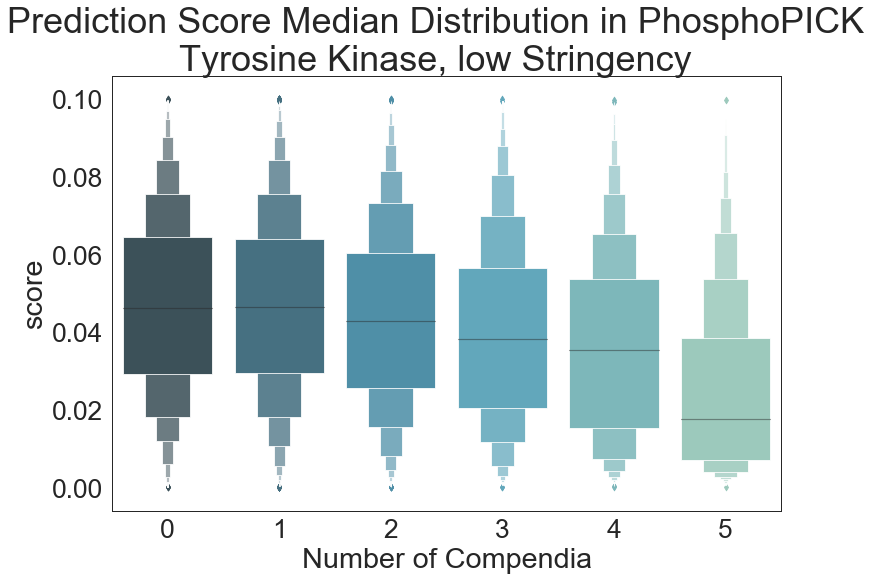

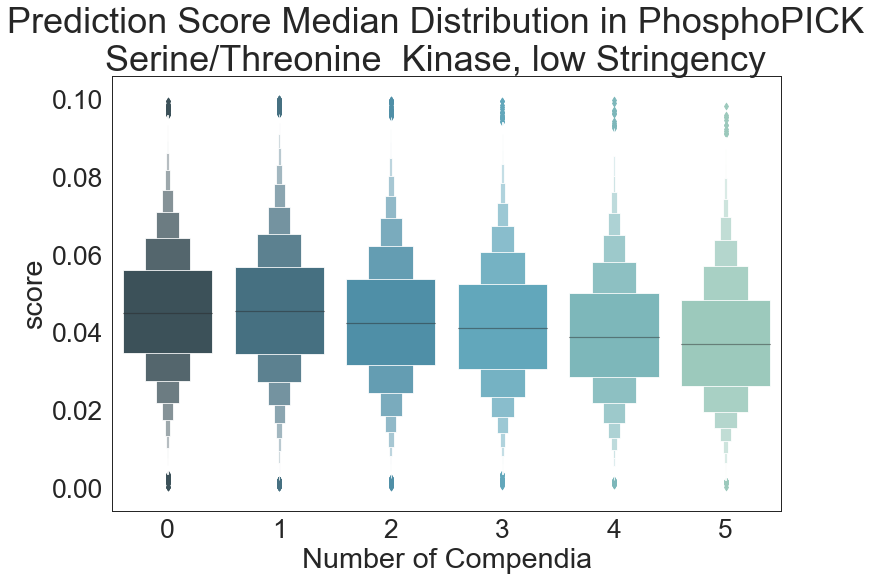

In [251]:
# plot
ks_pp_y = plot_score_numCompendia (pp_y, 'PhosphoPICK', 'low', 'Y_kinase')
ks_pp_st = plot_score_numCompendia (pp_st, 'PhosphoPICK', 'low', 'ST_kinase')

In [242]:
# print KS test results 
ks_pp = ks_pp_y.merge(ks_pp_st, left_on=['Group1', 'Group2'], right_on=['Group1', 'Group2'])
ks_pp = ks_pp.rename(columns={'statistic_x': 'statistic_PhosphoPICK_Y', 
                              'pvalue_x': 'pvalue_PhosphoPICK_Y',
                              'statistic_y': 'statistic_PhosphoPICK_ST', 
                              'pvalue_y': 'pvalue_PhosphoPICK_ST'})
ks_pp


,Group1,Group2,statistic_PhosphoPICK_Y,pvalue_PhosphoPICK_Y,statistic_PhosphoPICK_ST,pvalue_PhosphoPICK_ST
0,0.0,1.0,0.013673,7.121096e-02,0.004683,7.834146e-06
1,1.0,2.0,0.069006,1.911513e-87,0.033104,0.000000e+00
2,2.0,3.0,0.082927,2.069890e-46,0.011375,9.865205e-24
3,3.0,4.0,0.074789,2.430036e-22,0.021504,1.346564e-63
4,4.0,5.0,0.147779,1.554312e-15,0.023477,2.104235e-62


### NetworKIN

In [244]:
# get the number of compendia of the phosphosites
# by merge the prediction df with annotation df
nw03_y = prep_median_df (nw03_y, annot_df)
nw03_st = prep_median_df (nw03_st, annot_df)


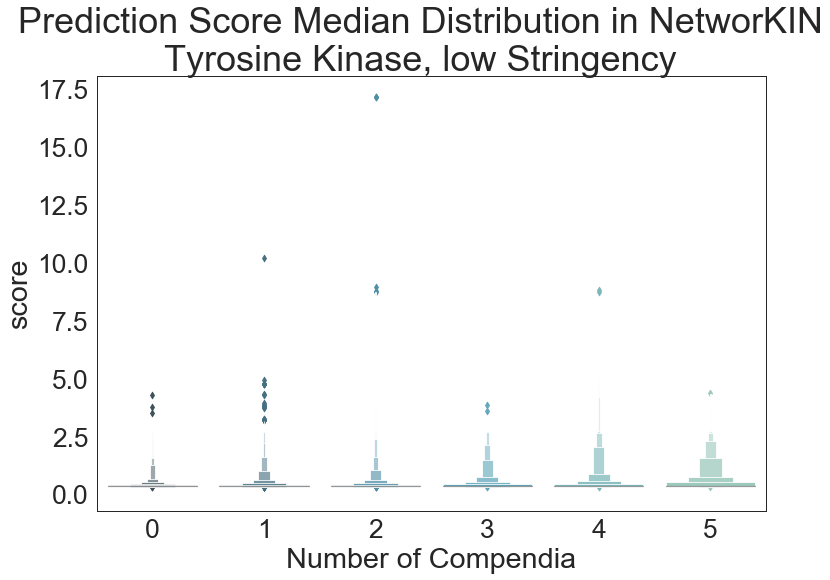

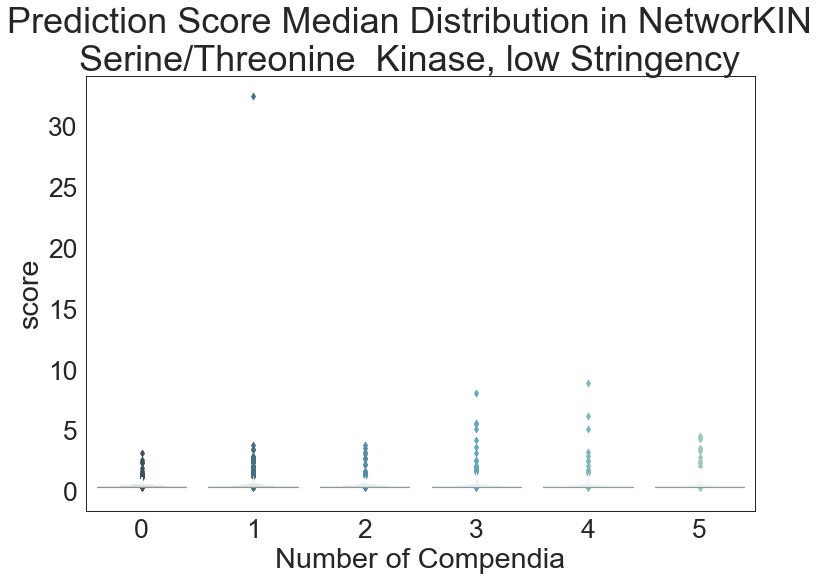

In [252]:
#plot
ks_nw_y = plot_score_numCompendia (nw03_y, 'NetworKIN', 'low', 'Y_kinase')
ks_nw_st = plot_score_numCompendia (nw03_st, 'NetworKIN', 'low', 'ST_kinase')

In [246]:
# print KS test result
ks_nw = ks_nw_y.merge(ks_nw_st, left_on=['Group1', 'Group2'], right_on=['Group1', 'Group2'])
ks_nw = ks_nw.rename(columns={'statistic_x': 'statistic_NetworKIN_Y', 
                              'pvalue_x': 'pvalue_NetworKIN_Y',
                              'statistic_y': 'statistic_NetworKIN_ST', 
                              'pvalue_y': 'pvalue_NetworKIN_ST'})
ks_nw


,Group1,Group2,statistic_NetworKIN_Y,pvalue_NetworKIN_Y,statistic_NetworKIN_ST,pvalue_NetworKIN_ST
0,0.0,1.0,0.084891,1.871042e-78,0.005373,1.112855e-07
1,1.0,2.0,0.052508,3.853171e-67,0.031599,0.000000e+00
2,2.0,3.0,0.057211,2.621627e-33,0.005365,1.831569e-05
3,3.0,4.0,0.064649,1.196203e-27,0.013586,2.929330e-24
4,4.0,5.0,0.062422,1.174670e-23,0.019905,1.453655e-41


### GPS5.0

In [247]:
# get the number of compendia of the phosphosites
# by merge the prediction df with annotation df
gpsl_y = prep_median_df (gpsl_y, annot_df)
gpsl_st = prep_median_df (gpsl_st, annot_df)


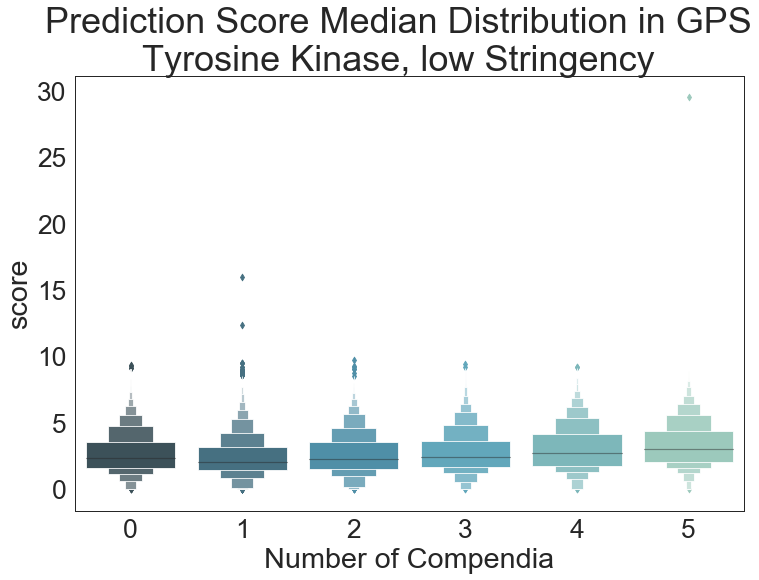

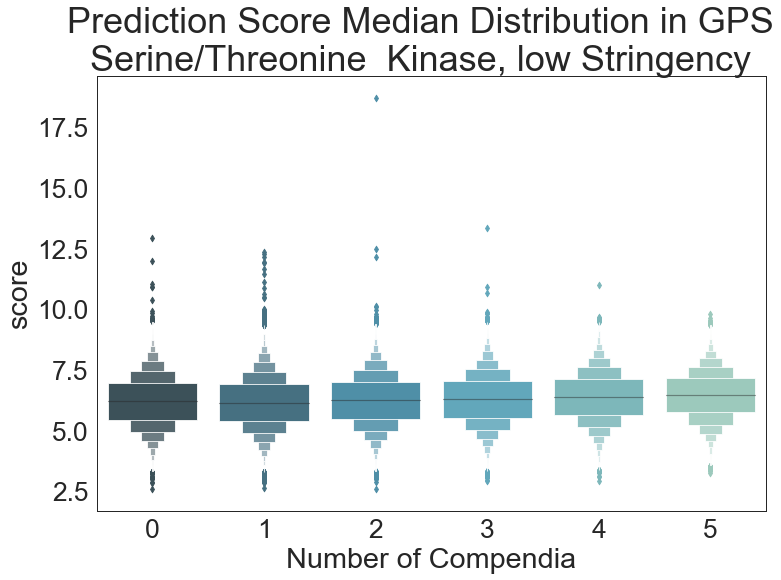

In [253]:
#plot 
ks_gps_y = plot_score_numCompendia (gps_y, 'GPS', 'low', 'Y_kinase')
ks_gps_st = plot_score_numCompendia (gps_st, 'GPS', 'low', 'ST_kinase')

In [249]:
# print KS test results
ks_gps = ks_gps_y.merge(ks_gps_st, left_on=['Group1', 'Group2'], right_on=['Group1', 'Group2'])
ks_gps = ks_gps.rename(columns={'statistic_x': 'statistic_GPS_Y', 
                              'pvalue_x': 'pvalue_GPS_Y',
                              'statistic_y': 'statistic_GPS_ST', 
                              'pvalue_y': 'pvalue_GPS_ST'})
ks_gps


,Group1,Group2,statistic_GPS_Y,pvalue_GPS_Y,statistic_GPS_ST,pvalue_GPS_ST
0,0.0,1.0,0.020867,1.976587e-22,0.005606,8.753218e-27
1,1.0,2.0,0.016963,3.118528e-27,0.009585,3.656295e-96
2,2.0,3.0,0.013776,5.203214e-06,0.003809,2.188499e-08
3,3.0,4.0,0.023036,3.173809e-08,0.007312,2.955586e-22
4,4.0,5.0,0.020185,3.677385e-04,0.005356,4.422514e-10


### Substrate Dregee Distribution vs. Number of Compendia 

In [255]:
def get_sub_degree(dfs, thresh, predictor, type):
    """
    get the substrate or kinase network degrees of the given dataframe
    
    Parameters
    ----------
    dfs: 
        dfs[0]: Y kinases
        dfs[1]: S/T kinases
    thresh: 
        'low', 'med', 'high'    
    predictor: 
        'PhosphoPICK', 'NetworKIN', 'GPS5.0'  
    type:
        'sub': get substrate network degrees 
        'kin': get substrate network degrees 
        
    Returns
    --------
        y:  substrate degree dataframe of the Y kinases
        st: substrate degree dataframe of the S/T kinases
    """
    if type == 'kin':
        groupby = 'Kinase Name'
        set_idx = 'substrate_id'
    elif type == 'sub':
        groupby = 'substrate_id'
        set_idx = 'Kinase Name'
        
    degs = []
    for df in dfs:
        deg = df.groupby([groupby,'substrate_acc', 'site', 'pep']).count()
        deg = deg[[set_idx]].reset_index()
        deg = deg.rename(columns={set_idx: 'degree'})
        # add threshold and predictor coloumns, these are needed to plot the violin plots
        deg['threshold'] = thresh
        deg['predictor'] = predictor
        degs.append(deg)
        
    y = degs[0]   # df of the degrees with only Y kinase
    st = degs[1]  # df of the degrees with only S/T kinase
    
    return y, st

In [256]:
def prep_degree_df (df, annot_df):
    """
    get the number of Compendia of a predicted site
    by merge the substrate degree df with the annotation df
    
    Parameters
    ----------
    df:       predicted substrate degree dataframe
    annot_df: annotation dataframe
    
    Returns
    --------
    df: merged dataframe
    """
    annot_df = annot_df.astype({'numCompendia':int})
    df = df.merge(annot_df, left_on=['substrate_acc', 'site'], right_on=['KSTAR_ACCESSION', 'KSTAR_SITE'], how = 'left')
    df = df.dropna(subset=['numCompendia', 'uniqueExpt'])

    return df

In [259]:
def plot_degree_numCompendia (df, predictor, thresh, kinase):
    """
    plot predicted substrate degree distributions by numbCompendia
    
    Parameters
    ----------
    df:  predicted substrate degree dataframe
    predictor: 
        'PhosphoPICK', 'NetworKIN', 'GPS'
    thresh: 
        'low','med','high'
    kinase:
        'Y_kinase','ST_kinase'
        
    Returns
    --------
    ks_result: KS test result summary of the predicted substrate degree between numCompendia groups
    """
    substrate degree dataframe of the Y kinases
    if kinase == 'Y_kinase':
        kin_name = 'Tyrosine Kinase'
    if kinase == 'ST_kinase':
        kin_name = 'Serine/Threonine  Kinase'
            
    df = df[df['threshold']==thresh]
    df = df.astype({'numCompendia':int})
#     df['degree'] = pd.to_numeric(df['degree'])
#     # ANOVA TEST
#     mod = ols('degree ~ numCompendia',
#                 data=df).fit()
#     aov_table = sm.stats.anova_lm(mod, typ=2)
#     print(aov_table)
    # KS TEST
    ks_result = pd.DataFrame(columns=['Group1', 'Group2', 'statistic', 'pvalue'])
    for i in range(0, df['numCompendia'].max()):
        result = stats.kstest(df[df['numCompendia']==i]['degree'], df[df['numCompendia']==i+1]['degree'])
        ks_result = ks_result.append({'Group1':i,
                                      'Group2':i+1,
                                      'statistic':result[0],
                                      'pvalue':result[1]}, 
                                     ignore_index=True)

    sns.set(context='paper', style='white', font_scale=3)
    plt.figure(figsize=(12,8))
    sns.boxenplot(x="numCompendia", y="degree", data=df, palette='GnBu_d', linewidth=1)
    plt.suptitle('Prediction Substrate Network Degree Distribution in ' + predictor, fontsize=36, y=1)
    plt.title(kin_name + ', ' + thresh + ' Stringency', fontsize=30, y=1)
    plt.xlabel('Number of Compendia')
    plt.savefig(plot_dir + predictor + '_' + thresh + '_' + kinase + '_compendia_subDegree.svg', format='svg', bbox_inches="tight")
    plt.show()
    
    return ks_result
    

### PhosphoPICK

In [322]:
# get the substrate degrees
pp_deg_l_y, pp_deg_l_st = get_sub_degree([pp1_y, pp1_st], 'low', 'PhosphoPICK', 'sub')
pp_deg_m_y, pp_deg_m_st = get_sub_degree([pp06_y, pp06_st], 'med', 'PhosphoPICK', 'sub')
pp_deg_h_y, pp_deg_h_st = get_sub_degree([pp02_y, pp02_st], 'high', 'PhosphoPICK', 'sub')


In [323]:
# get the number of compendia of the phosphosites
# by merge the prediction df with annotation df
pp_deg_l_y = prep_df (pp_deg_l_y, annot_df)
pp_deg_l_st = prep_df (pp_deg_l_st, annot_df)
pp_deg_m_y = prep_df (pp_deg_m_y, annot_df)
pp_deg_m_st = prep_df (pp_deg_m_st, annot_df)
pp_deg_h_y = prep_df (pp_deg_h_y, annot_df)
pp_deg_h_st = prep_df (pp_deg_h_st, annot_df)

In [324]:
# concat dfs
# Y kinases
df_y_sub = pd.concat([pp_deg_l_y, pp_deg_m_y, pp_deg_h_y])
# S/T kinases
df_st_sub = pd.concat([pp_deg_l_st, pp_deg_m_st, pp_deg_h_st])

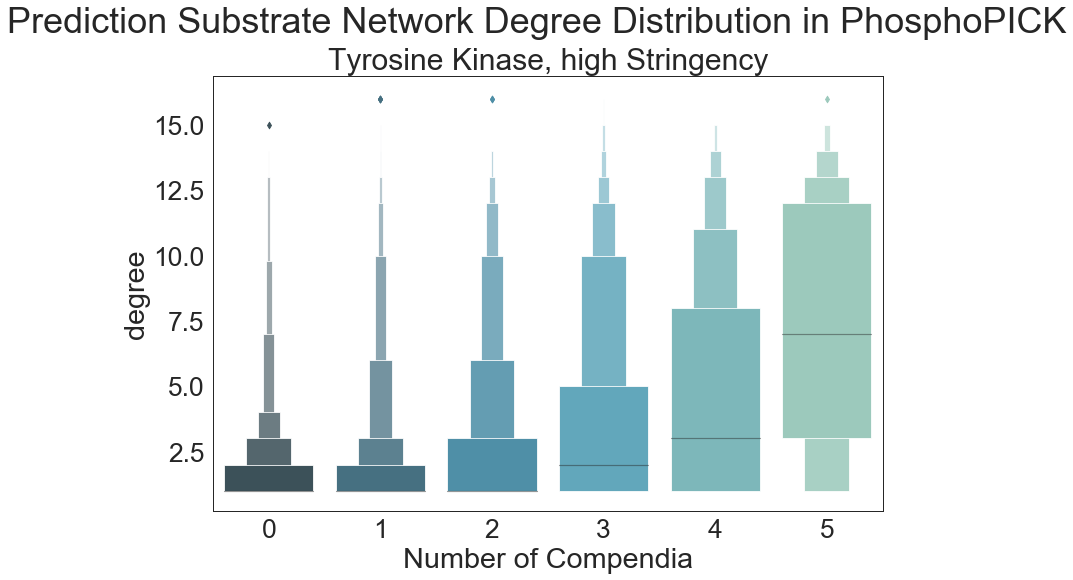

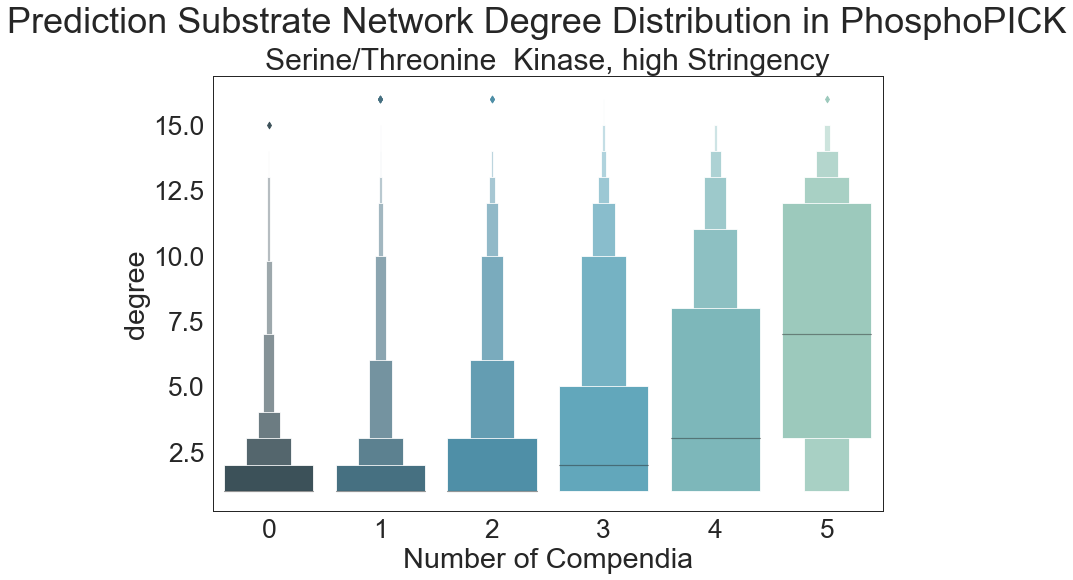

In [261]:
# plot
ks_pp_y = plot_degree_numCompendia (df_y_sub, 'PhosphoPICK', 'high', 'Y_kinase')
ks_pp_st = plot_degree_numCompendia (df_y_sub, 'PhosphoPICK', 'high', 'ST_kinase')

In [262]:
# print KS test result
ks_pp = ks_pp_y.merge(ks_pp_st, left_on=['Group1', 'Group2'], right_on=['Group1', 'Group2'])
ks_pp = ks_pp.rename(columns={'statistic_x': 'statistic_PhosphoPICK_Y', 
                              'pvalue_x': 'pvalue_PhosphoPICK_Y',
                              'statistic_y': 'statistic_PhosphoPICK_ST', 
                              'pvalue_y': 'pvalue_PhosphoPICK_ST'})
ks_pp


,Group1,Group2,statistic_PhosphoPICK_Y,pvalue_PhosphoPICK_Y,statistic_PhosphoPICK_ST,pvalue_PhosphoPICK_ST
0,0.0,1.0,0.036643,5.572676e-02,0.036643,5.572676e-02
1,1.0,2.0,0.086644,2.263466e-18,0.086644,2.263466e-18
2,2.0,3.0,0.119057,7.160605e-12,0.119057,7.160605e-12
3,3.0,4.0,0.114569,3.931457e-06,0.114569,3.931457e-06
4,4.0,5.0,0.265370,3.484533e-22,0.265370,3.484533e-22


### NetworKIN

In [308]:
# get the substrate degrees
nw_deg_l_y, nw_deg_l_st = get_sub_degree([nw03_y, nw03_st], 'low', 'NetworKIN', 'sub')
nw_deg_m_y, nw_deg_m_st = get_sub_degree([nw05_y, nw05_st], 'med', 'NetworKIN', 'sub')
nw_deg_h_y, nw_deg_h_st = get_sub_degree([nw1_y, nw1_st], 'high', 'NetworKIN', 'sub')


In [309]:
# get the number of compendia of the phosphosites
# by merge the prediction df with annotation df
nw_deg_l_y = prep_df (nw_deg_l_y, annot_df)
nw_deg_l_st = prep_df (nw_deg_l_st, annot_df)
nw_deg_m_y = prep_df (nw_deg_m_y, annot_df)
nw_deg_m_st = prep_df (nw_deg_m_st, annot_df)
nw_deg_h_y = prep_df (nw_deg_h_y, annot_df)
nw_deg_h_st = prep_df (nw_deg_h_st, annot_df)

In [310]:
# concat dfs
# Y kinases
df_y_sub = pd.concat([nw_deg_l_y, nw_deg_m_y, nw_deg_h_y])
# S/T kinases
df_st_sub = pd.concat([nw_deg_l_st, nw_deg_m_st, nw_deg_h_st])

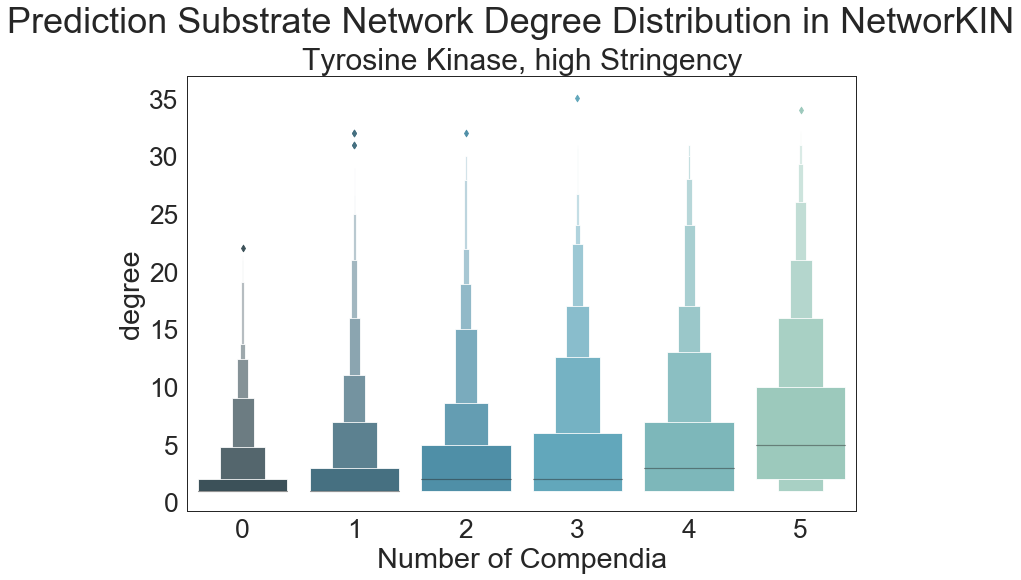

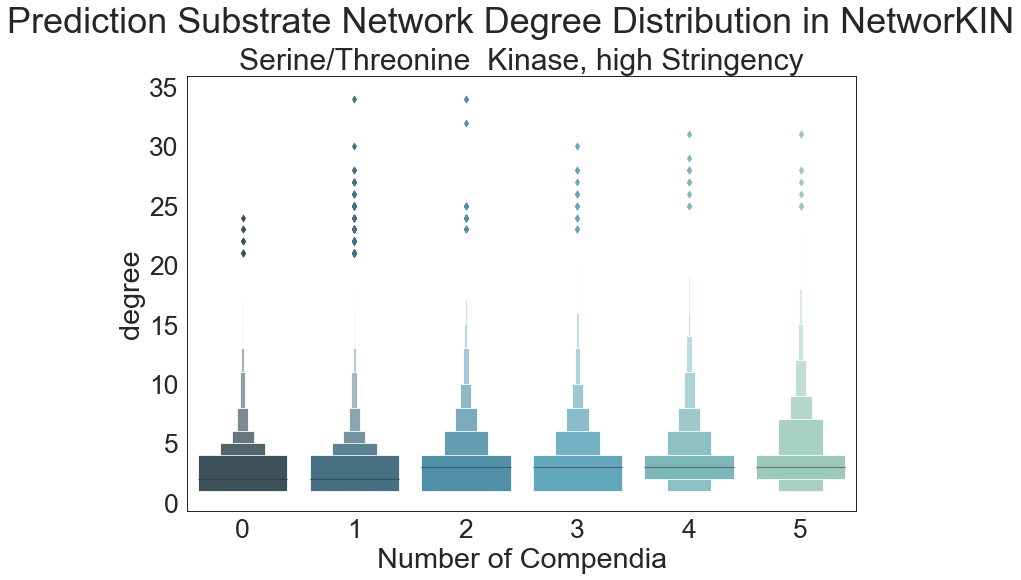

In [266]:
# plot
ks_nw_y = plot_degree_numCompendia (df_y_sub, 'NetworKIN', 'high', 'Y_kinase')
ks_nw_st = plot_degree_numCompendia (df_st_sub, 'NetworKIN', 'high', 'ST_kinase')

In [267]:
# print KS test results
ks_nw = ks_nw_y.merge(ks_nw_st, left_on=['Group1', 'Group2'], right_on=['Group1', 'Group2'])
ks_nw = ks_nw.rename(columns={'statistic_x': 'statistic_NetworKIN_Y', 
                              'pvalue_x': 'pvalue_NetworKIN_Y',
                              'statistic_y': 'statistic_NetworKIN_ST', 
                              'pvalue_y': 'pvalue_NetworKIN_ST'})
ks_nw


,Group1,Group2,statistic_NetworKIN_Y,pvalue_NetworKIN_Y,statistic_NetworKIN_ST,pvalue_NetworKIN_ST
0,0.0,1.0,0.075037,5.823955e-02,0.010225,1.075194e-01
1,1.0,2.0,0.108770,3.876273e-10,0.044980,1.655390e-31
2,2.0,3.0,0.093275,1.542256e-03,0.011089,2.024870e-01
3,3.0,4.0,0.083463,3.937541e-02,0.013423,1.790075e-01
4,4.0,5.0,0.152397,1.819505e-05,0.026159,1.604991e-03


### GPS

In [315]:
# get the substrate degrees
gps_deg_l_y, gps_deg_l_st = get_sub_degree([gpsl_y, gpsl_st], 'low', 'GPS', 'sub')
gps_deg_m_y, gps_deg_m_st = get_sub_degree([gpsm_y, gpsm_st], 'med', 'GPS', 'sub')
gps_deg_h_y, gps_deg_h_st = get_sub_degree([gpsh_y, gpsh_st], 'high', 'GPS', 'sub')


In [316]:
# get the number of compendia of the phosphosites
# by merge the prediction df with annotation df
gps_deg_l_y = prep_df (gps_deg_l_y, annot_df)
gps_deg_l_st = prep_df (gps_deg_l_st, annot_df)
gps_deg_m_y = prep_df (gps_deg_m_y, annot_df)
gps_deg_m_st = prep_df (gps_deg_m_st, annot_df)
gps_deg_h_y = prep_df (gps_deg_h_y, annot_df)
gps_deg_h_st = prep_df (gps_deg_h_st, annot_df)

In [317]:
# concat dfs
# Y kinases
df_y_sub = pd.concat([gps_deg_l_y, gps_deg_m_y, gps_deg_h_y])
# S/T kinases
df_st_sub = pd.concat([gps_deg_l_st, gps_deg_m_st, gps_deg_h_st])

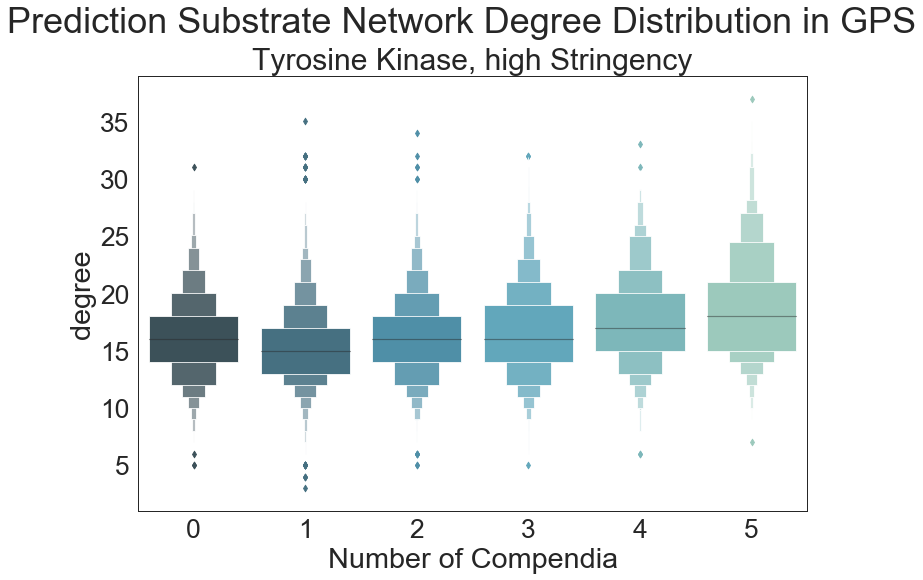

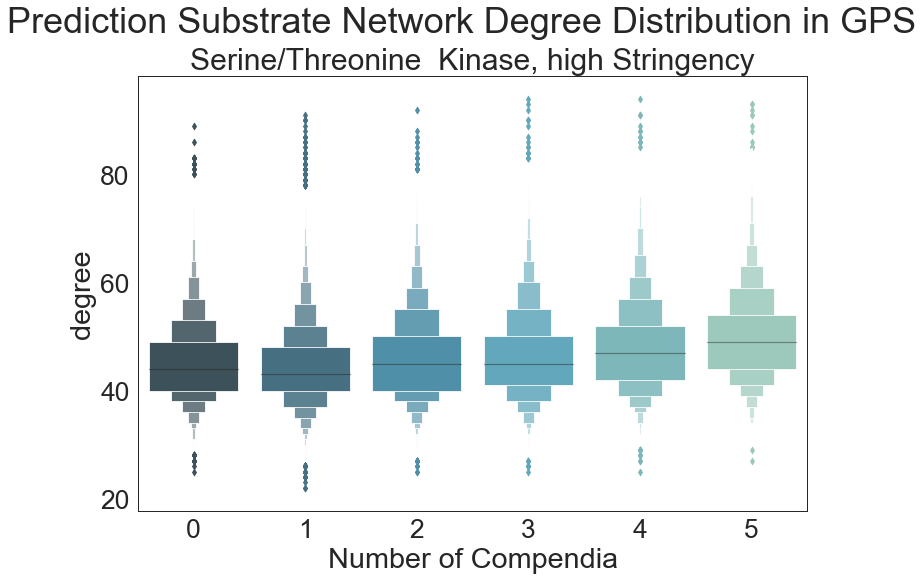

In [271]:
# plot 
ks_gps_y = plot_degree_numCompendia (df_y_sub, 'GPS', 'high', 'Y_kinase')
ks_gps_st = plot_degree_numCompendia (df_st_sub, 'GPS', 'high', 'ST_kinase')

In [273]:
# print KS test results
ks_gps = ks_gps_y.merge(ks_gps_st, left_on=['Group1', 'Group2'], right_on=['Group1', 'Group2'])
ks_gps = ks_gps.rename(columns={'statistic_x': 'statistic_GPS_Y', 
                              'pvalue_x': 'pvalue_GPS_Y',
                              'statistic_y': 'statistic_GPS_ST', 
                              'pvalue_y': 'pvalue_GPS_ST'})
ks_gps


,Group1,Group2,statistic_GPS_Y,pvalue_GPS_Y,statistic_GPS_ST,pvalue_GPS_ST
0,0.0,1.0,0.083151,6.128921e-18,0.035539,3.866737e-20
1,1.0,2.0,0.057319,3.887269e-16,0.075099,1.869808e-107
2,2.0,3.0,0.057552,3.024347e-05,0.034644,3.802274e-12
3,3.0,4.0,0.091132,3.184954e-06,0.092962,1.159554e-60
4,4.0,5.0,0.120889,2.369478e-06,0.099675,2.324313e-54
